<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/MLP/HyperMixer/hypermixer%20on%20Hissar_sentinel%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select the best

def str_to_bool(x):
    return True if x == "True" else False

use_pearson_corr = "False"  #@param ["True", "False"]
add_pos_embedding = "False"  #@param ["True", "False"]
patch_method = "extract"    #@param ["extract", "conv"]

H, W, B = 722, 1014, 4               # height,width and band of image
P_S = 9                             #@param [3, 9, 15, 21]                         
patch_size = 3                      # Size of the patches to be extract from the input images
# valid patch size is that number which is divisible by 3 i.e. 3,6,9,12

train_percent = 75          #@param [75, 80, 90]
epoch = "300"               #@param [100, 200, 300, 400]

LR_START = 3e-3
LR_MAX = 6e-3 
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
num_patches = (P_S//patch_size)**2

projection_dim = "128"       #@param [64, 128, 256, 512, 1024, 2048]
hidden_dim = "64"            #@param [32, 64, 128, 256, 512, 1024]
dropout_ratio = 0.0         #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]
drop_path = 0.0             #@param ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5"]

use_pearson_corr = str_to_bool(use_pearson_corr)
add_pos_embedding = str_to_bool(add_pos_embedding)

P_S = int(P_S)
train_percent = int(train_percent)
epoch = int(epoch)
hidden_dim = int(hidden_dim) 
channels_mlp_dim = hidden_dim
projection_dim = int(projection_dim)
dropout_ratio = float(dropout_ratio)
drop_path = int(drop_path)


print("Number of patches per P_S: ", num_patches)
print("Size of each patch for MLP Mixture: ", patch_size)

Number of patches per P_S:  9
Size of each patch for MLP Mixture:  3


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc
import pickle

import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input,Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate,LayerNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling1D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply, Layer, MaxPool2D, UpSampling2D, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral
from imgaug import augmenters as iaa
import imgaug as ia
tfds.disable_progress_bar()
tf.random.set_seed(42)
ia.seed(42)

AUTO = tf.data.AUTOTUNE
np.random.seed(1337)          # to get reproducible results
if use_pearson_corr:
    folder_path = "/content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/With Pearson correlation/"
else:
    folder_path = "/content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/"

try:
    os.mkdir(folder_path)
except:
    pass

In [ ]:
x_csv = np.array(si.loadmat('/content/drive/My Drive/m_p/data/Hissar_25%/datas.mat')['datas'])
y_csv = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/Hissar_25%/fullgt.csv'))

x= np.zeros((H, W, B))
x[:,:,:B], y = x_csv.reshape(H,W,B), y_csv.reshape(H,W)
x = x.astype('float16')

# Normalizing the data between 0,1
for i in range(B):
    band_min = x[:,:,i].min()
    band_max = x[:,:,i].max()
    band_range = band_max - band_min
    temp = (x[:,:,i] - band_min)/band_range
    x[:,:,i] = temp
    # x[:,:,B+i] = cv2.equalizeHist((temp*255).astype(np.uint8))/255.0

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1


print("shape of x_csv: ", x_csv.shape)
print("shape of y_csv: ", y_csv.shape)
print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape)
print()
print(f"{len(Y)*100/y_csv.shape[0]}% of data is labeled with {num_classes} classes")

shape of x_csv:  (732108, 4)
shape of y_csv:  (732108, 1)

minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (722, 1014, 4)
shape of y:  (722, 1014)

shape of padded_x:  (730, 1022, 4)

6.123003709835161% of data is labeled with 8 classes


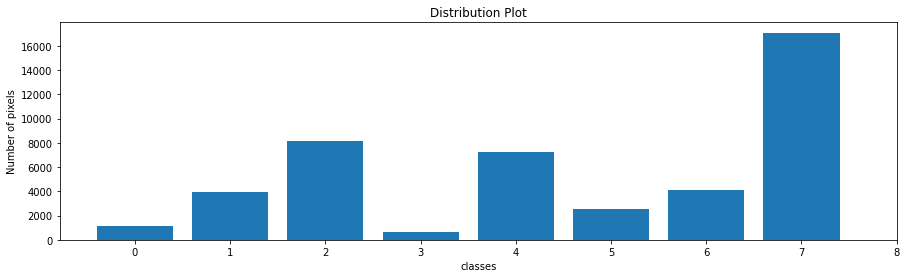

In [ ]:
class_labels, value_counts = np.unique(y_csv, return_counts = True)
plt.figure(figsize = (15,4))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train, x_test,y_train,y_test = tf.cast(np.array(x_train), tf.float32), tf.cast(np.array(x_test), tf.float32), np.array(y_train), np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (33620, 9, 9, 4) 
x_test: (11207, 9, 9, 4) 
y_train: (33620,) 
y_test: (11207,)


### Prediction and performance measure functions

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        try:
            os.mkdir(folder_path + "Results/")
        except:
            pass
        if use_pearson_corr:
            path = folder_path + "Results/Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png"
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)

    try:
        os.mkdir(folder_path + "Results/" )
    except:
        pass

    if folder_path:
        if use_pearson_corr:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure" + ".png"
        else:
            path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S)+ " Performance Measure" + ".png"
        fig.savefig(path)

### Building the classes and function for model

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S
    
    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))
    
        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)
    
        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

In [ ]:
class Patches(layers.Layer):
    def __init__(self, hidden_dim = 256, patch_size = 3, patch_method='extract', **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.patch_method = patch_method.lower()

    def call(self, images):
        if self.patch_method == "conv":
            x = Conv2D(self.hidden_dim, patch_size, patch_size)(images)              # shape(B, 3, 3, 256)
            patches = Reshape([-1, x.shape[-1]])(x)                                   # shape(B, 9, 256)
            return patches
        else:
            batch_size = tf.shape(images)[0]
            patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1],
                                            rates=[1, 1, 1, 1], padding="VALID",)
            patch_dims = patches.shape[-1]
            patches = tf.reshape(patches, [batch_size, -1, patch_dims])
            return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "hidden_dim": self.hidden_dim,
            "patch_method": self.patch_method
        })
        return config

In [ ]:
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim, **kwargs):
#         super(PatchEncoder, self).__init__(**kwargs)
#         self.num_patches = num_patches
#         self.projection_dim = projection_dim
#         self.projection = Dense(projection_dim)
#         self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

#     def call(self, patch,**kwargs):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)    # (9, 512)
#         return encoded

#     def get_config(self, **kwargs):
#         config = super().get_config()
#         config.update({
#             "num_patches": self.num_patches,
#             "projection_dim": self.projection_dim,
#         })
#         return config

In [ ]:
class PositionEmbedding(layers.Layer):
    def __init__(self, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)

    def call(self, patch,**kwargs):
        shape = tf.shape(patch)
        positions = tf.range(start=0, limit=shape[-2], delta=1)
        position_embedding = layers.Embedding(input_dim=num_patches, output_dim=shape[-2])
        encoded = patch + position_embedding(positions)    # (9, 512)
        return encoded

In [ ]:
class Drop_Path(layers.Layer):
    def __init__(self, drop_prob = 0.0, training = False, **kwargs):
        super(Drop_Path, self).__init__(**kwargs)
        self.drop_prob = drop_prob
        self.training = training
    def call(self, x, **kwargs):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 -  self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        random_tensor.floor_()  # binarize
        output = tf.divide(x, keep_prob) * random_tensor
        return output
    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "drop_prob": self.drop_prob,
            "training": self.training,
        })
        return config

In [ ]:
class MLP(layers.Layer):
    def __init__(self, in_features, out_features, drop = 0.0, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.drop = drop
        self.mlp_1 = Dense(in_features, activation = activations.gelu, use_bias = False)
        self.drop_1 = Dropout(drop)
        self.mlp_2 = Dense(out_features, activation = activations.gelu, use_bias = False)
        self.drop_2 = Dropout(drop)

    def call(self, x):
        x = self.drop_1(self.mlp_1(x))
        x = self.drop_2(self.mlp_2(x))
        return x

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "in_features": self.in_features,
            "out_features": self.out_features,
            "drop": self.drop,
        })
        return config

In [ ]:
class HyperMixer(layers.Layer):
    def __init__(self, num_patches, dim, hidden_dim, add_pos_embedding = False, dropout_ratio = 0.0, **kwargs):
        super(HyperMixer, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.add_pos_embedding = add_pos_embedding
        self.dropout_ratio = dropout_ratio
        # hidden_dim
        self.mlp_1 = MLP(hidden_dim, dim, drop = dropout_ratio)
        self.drop = Dropout(dropout_ratio)
    def call(self, x, **kwargs):
        # mlp_1 = Dense(hidden_dim, activation=activations.gelu, use_bias=False)                              
        # drop = Dropout(dropout_ratio)
        # act = activations.gelu()

        if self.add_pos_embedding:
            weights = PositionEmbedding()(x)                      # (9, 512)
        else:
            weights = x + x
        weights = self.mlp_1(weights)                                                    # (9, 512)
        x = self.drop(activations.gelu(tf.transpose(weights, (0,2,1)) @ x))                                  # (512, 512)
        x = self.drop(weights@x)                                                       # (9, 512)
        return x

    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "dim": self.dim,
            "hidden_dim": self.hidden_dim,
            "add_pos_embedding": self.add_pos_embedding,
            "dropout_ratio": self.dropout_ratio,
        })
        return config

In [ ]:
class HyperMixerBlock(layers.Layer):
    def __init__(self, num_patches, dim, mlp_ratio = (0.5, 4), add_pos_embedding = False, dropout_ratio = 0.0, drop_path = 0.0, **kwargs):
        super(HyperMixerBlock, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.dim = dim
        self.mlp_ratio = mlp_ratio
        tokens_dim, channels_dim = [int(i*self.dim) for i in self.mlp_ratio]
        self.add_pos_embedding = add_pos_embedding
        self.dropout_ratio = dropout_ratio
        self.drop_path = drop_path

        self.norm1 = LayerNormalization(axis = -1, epsilon=1e-6)
        # self.norm1 = BatchNormalization()
        self.norm2 = LayerNormalization(axis = -1, epsilon=1e-6)
        self.mlp_channels = MLP(channels_dim, dim, drop = dropout_ratio)
        # tokens_dim = 256
        # channels_dim = 2048
        self.mlp_tokens = HyperMixer(num_patches = self.num_patches, dim=self.dim, hidden_dim=tokens_dim, add_pos_embedding = self.add_pos_embedding , dropout_ratio=self.dropout_ratio)   # (9, 512)
        # self.mlp_channels = Dense(2048, activation = activations.gelu, use_bias=False)
        self.DropPath = Drop_Path(drop_prob = self.drop_path, training = False)
        # self.mlp_1 = Dense(hidden_dim, activation=activations.gelu, use_bias=False)
        # self.drop = Dropout(dropout_ratio)
    def call(self, x, **kwargs):
        x = self.norm1(x)                                                       # (9, 512)  
        x = x + self.DropPath(self.mlp_tokens(x))                               # (9, 512)
        x = x + self.DropPath(self.mlp_channels(self.norm2(x)))                 # (9, 512)
        return x
    def get_config(self, **kwargs):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "dim": self.dim,
            # "mlp_ratio": self.mlp_ratio,
            "add_pos_embedding": self.add_pos_embedding,
            "dropout_ratio": self.dropout_ratio,
            "drop_path": self.drop_path
        })
        return config

In [ ]:
def HyperMixer_classifier(input_shape = (P_S, P_S, B), classes = 13, use_pearson_corr = False, num_patches = 9, projection_dim = 2048, hidden_dim = 512, 
                          add_pos_embedding = True, dropout_ratio = 0.0, drop_path = 0.0):
    add_pos_embedding = False
    inputs = layers.Input(shape=input_shape)                                                # shape = (9,9,372)
    # b = inputs.shape[0]
    # Create patches.
    if use_pearson_corr:
        x0 = Pearson_correlation_masked(P_S)(inputs)                                        # shape = (9,9,372)
    else:
        x0 = inputs
    patches = Patches(hidden_dim=projection_dim,patch_size=patch_size)(x0)              # shape = 9, 3348 ----> 9 patches each shape 3*3*372 = 3348
    
    patches = Dense(hidden_dim)(patches)                  # (9, 512)
    x = HyperMixerBlock(num_patches = num_patches, dim = hidden_dim, mlp_ratio = (0.5, 4), add_pos_embedding = add_pos_embedding, dropout_ratio = dropout_ratio,
                        drop_path = dropout_ratio)(patches)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax", dtype="float32")(x)
    model = Model(inputs = inputs, outputs = outputs, name = "Hyper_Mixer")
    return model

In [ ]:
model = HyperMixer_classifier(input_shape = (P_S, P_S, B), classes = num_classes, use_pearson_corr = use_pearson_corr, num_patches = num_patches, projection_dim = projection_dim, 
                              hidden_dim = hidden_dim, add_pos_embedding = add_pos_embedding, dropout_ratio = dropout_ratio, drop_path = drop_path)

In [ ]:
model.summary()

Model: "Hyper_Mixer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 4)]         0         
                                                                 
 patches (Patches)           (None, None, 36)          0         
                                                                 
 dense (Dense)               (None, None, 64)          2368      
                                                                 
 hyper_mixer_block (HyperMix  (None, None, 64)         37120     
 erBlock)                                                        
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_5 (Dense)             (None, 8)                 

In [ ]:
# def mlp_block(x, hidden_dim, dropout_ratio = 0.1):
#     y = Dense(hidden_dim)(x)
#     y = tf.nn.gelu(y)
#     y = Dropout(dropout_ratio)(y)
#     return Dense(x.shape[-1])(y)

# # hidden_dim = mlp_dim = 128, 256

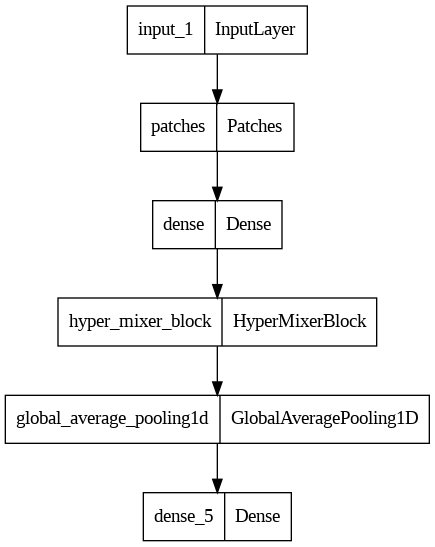

In [ ]:
plot_model(model)

Learning rate schedule: 0.0006 to 0.0006 to 1e-07


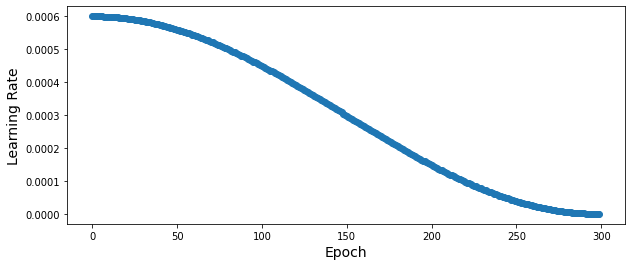

In [ ]:
LR_START = 3e-4
LR_MAX = 6e-4 
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
filepath = folder_path +"Trained models/"+ str(train_percent)+"% ps_"+str(P_S)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
callbacks_list = [checkpoint, lr_callback]
model.compile(optimizer=optimizers.Adam(0.000003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(train_dataset, validation_data = (test_dataset), validation_freq = 1, batch_size = 32, callbacks=callbacks_list, shuffle = False, epochs=epochs)
start_time = time.time()
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), validation_freq = 1, batch_size = BATCH_SIZE, callbacks=callbacks_list, shuffle = False, 
                    epochs=epoch, use_multiprocessing=True)
end_time = time.time()
tt = end_time - start_time
print("total training time: ", tt)


Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/300
263/263 [==============================] - ETA: 0s - loss: 38.2154 - accuracy: 0.5449
Epoch 1: val_accuracy improved from -inf to 0.67833, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 23s 52ms/step - loss: 38.2154 - accuracy: 0.5449 - val_loss: 0.9761 - val_accuracy: 0.6783 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005999834433585453.
Epoch 2/300
262/263 [============================>.] - ETA: 0s - loss: 0.9042 - accuracy: 0.6877
Epoch 2: val_accuracy improved from 0.67833 to 0.71750, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 10s 39ms/step - loss: 0.9039 - accuracy: 0.6878 - val_loss: 0.8326 - val_accuracy: 0.7175 - lr: 5.9998e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005999337752619684.
Epoch 3/300
258/263 [============================>.] - ETA: 0s - loss: 0.7813 - accuracy: 0.7393
Epoch 3: val_accuracy improved from 0.71750 to 0.76131, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 24ms/step - loss: 0.7809 - accuracy: 0.7394 - val_loss: 0.7167 - val_accuracy: 0.7613 - lr: 5.9993e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005998510011934292.
Epoch 4/300
258/263 [============================>.] - ETA: 0s - loss: 0.6950 - accuracy: 0.7685
Epoch 4: val_accuracy improved from 0.76131 to 0.78157, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.6948 - accuracy: 0.7685 - val_loss: 0.6548 - val_accuracy: 0.7816 - lr: 5.9985e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005997351302908542.
Epoch 5/300
260/263 [============================>.] - ETA: 0s - loss: 0.6355 - accuracy: 0.7916
Epoch 5: val_accuracy improved from 0.78157 to 0.80146, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 23ms/step - loss: 0.6355 - accuracy: 0.7916 - val_loss: 0.6032 - val_accuracy: 0.8015 - lr: 5.9974e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0005995861753459288.
Epoch 6/300
263/263 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.8035
Epoch 6: val_accuracy improved from 0.80146 to 0.81431, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.5947 - accuracy: 0.8035 - val_loss: 0.5673 - val_accuracy: 0.8143 - lr: 5.9959e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0005994041528026842.
Epoch 7/300
258/263 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.8109
Epoch 7: val_accuracy improved from 0.81431 to 0.82377, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.5675 - accuracy: 0.8108 - val_loss: 0.5421 - val_accuracy: 0.8238 - lr: 5.9940e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0005991890827556831.
Epoch 8/300
262/263 [============================>.] - ETA: 0s - loss: 0.5484 - accuracy: 0.8169
Epoch 8: val_accuracy improved from 0.82377 to 0.82654, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.5481 - accuracy: 0.8171 - val_loss: 0.5235 - val_accuracy: 0.8265 - lr: 5.9919e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0005989409889478.
Epoch 9/300
260/263 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.8214
Epoch 9: val_accuracy improved from 0.82654 to 0.83198, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.5332 - accuracy: 0.8211 - val_loss: 0.5094 - val_accuracy: 0.8320 - lr: 5.9894e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0005986598987676014.
Epoch 10/300
263/263 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8247
Epoch 10: val_accuracy improved from 0.83198 to 0.83546, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 20ms/step - loss: 0.5208 - accuracy: 0.8247 - val_loss: 0.4979 - val_accuracy: 0.8355 - lr: 5.9866e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0005983458432463212.
Epoch 11/300
259/263 [============================>.] - ETA: 0s - loss: 0.5096 - accuracy: 0.8283
Epoch 11: val_accuracy improved from 0.83546 to 0.83956, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 20ms/step - loss: 0.5097 - accuracy: 0.8279 - val_loss: 0.4871 - val_accuracy: 0.8396 - lr: 5.9835e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0005979988570544356.
Epoch 12/300
259/263 [============================>.] - ETA: 0s - loss: 0.4994 - accuracy: 0.8324
Epoch 12: val_accuracy improved from 0.83956 to 0.84394, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.4995 - accuracy: 0.8321 - val_loss: 0.4791 - val_accuracy: 0.8439 - lr: 5.9800e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0005976189784978356.
Epoch 13/300
260/263 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.8359
Epoch 13: val_accuracy improved from 0.84394 to 0.84581, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 22ms/step - loss: 0.4903 - accuracy: 0.8357 - val_loss: 0.4729 - val_accuracy: 0.8458 - lr: 5.9762e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0005972062495135974.
Epoch 14/300
262/263 [============================>.] - ETA: 0s - loss: 0.4822 - accuracy: 0.8388
Epoch 14: val_accuracy improved from 0.84581 to 0.84956, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.4819 - accuracy: 0.8388 - val_loss: 0.4674 - val_accuracy: 0.8496 - lr: 5.9721e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0005967607156653538.
Epoch 15/300
259/263 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.8418
Epoch 15: val_accuracy improved from 0.84956 to 0.85152, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.4739 - accuracy: 0.8417 - val_loss: 0.4618 - val_accuracy: 0.8515 - lr: 5.9676e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0005962824261382637.
Epoch 16/300
262/263 [============================>.] - ETA: 0s - loss: 0.4662 - accuracy: 0.8442
Epoch 16: val_accuracy improved from 0.85152 to 0.85340, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.4659 - accuracy: 0.8443 - val_loss: 0.4555 - val_accuracy: 0.8534 - lr: 5.9628e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0005957714337335819.
Epoch 17/300
260/263 [============================>.] - ETA: 0s - loss: 0.4579 - accuracy: 0.8471
Epoch 17: val_accuracy improved from 0.85340 to 0.85464, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.4581 - accuracy: 0.8469 - val_loss: 0.4481 - val_accuracy: 0.8546 - lr: 5.9577e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.0005952277948628305.
Epoch 18/300
261/263 [============================>.] - ETA: 0s - loss: 0.4500 - accuracy: 0.8487
Epoch 18: val_accuracy improved from 0.85464 to 0.85732, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 20ms/step - loss: 0.4501 - accuracy: 0.8485 - val_loss: 0.4398 - val_accuracy: 0.8573 - lr: 5.9523e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0005946515695415714.
Epoch 19/300
256/263 [============================>.] - ETA: 0s - loss: 0.4416 - accuracy: 0.8518
Epoch 19: val_accuracy improved from 0.85732 to 0.86027, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 7s 28ms/step - loss: 0.4421 - accuracy: 0.8515 - val_loss: 0.4318 - val_accuracy: 0.8603 - lr: 5.9465e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0005940428213827801.
Epoch 20/300
263/263 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8542
Epoch 20: val_accuracy improved from 0.86027 to 0.86232, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.4338 - accuracy: 0.8542 - val_loss: 0.4249 - val_accuracy: 0.8623 - lr: 5.9404e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.000593401617589824.
Epoch 21/300
262/263 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.8582
Epoch 21: val_accuracy improved from 0.86232 to 0.86544, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 23ms/step - loss: 0.4243 - accuracy: 0.8581 - val_loss: 0.4148 - val_accuracy: 0.8654 - lr: 5.9340e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0005927280289490428.
Epoch 22/300
257/263 [============================>.] - ETA: 0s - loss: 0.4135 - accuracy: 0.8621
Epoch 22: val_accuracy improved from 0.86544 to 0.87017, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.4140 - accuracy: 0.8617 - val_loss: 0.3983 - val_accuracy: 0.8702 - lr: 5.9273e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.000592022129821934.
Epoch 23/300
258/263 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8670
Epoch 23: val_accuracy improved from 0.87017 to 0.87615, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.4032 - accuracy: 0.8668 - val_loss: 0.3793 - val_accuracy: 0.8761 - lr: 5.9202e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0005912839981369443.
Epoch 24/300
262/263 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.8717
Epoch 24: val_accuracy improved from 0.87615 to 0.88132, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.3924 - accuracy: 0.8717 - val_loss: 0.3634 - val_accuracy: 0.8813 - lr: 5.9128e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0005905137153808655.
Epoch 25/300
262/263 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8753
Epoch 25: val_accuracy improved from 0.88132 to 0.88605, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.3815 - accuracy: 0.8753 - val_loss: 0.3503 - val_accuracy: 0.8861 - lr: 5.9051e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0005897113665898402.
Epoch 26/300
263/263 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8796
Epoch 26: val_accuracy improved from 0.88605 to 0.89105, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.3703 - accuracy: 0.8796 - val_loss: 0.3403 - val_accuracy: 0.8911 - lr: 5.8971e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0005888770403399724.
Epoch 27/300
262/263 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8837
Epoch 27: val_accuracy improved from 0.89105 to 0.89239, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.3591 - accuracy: 0.8837 - val_loss: 0.3335 - val_accuracy: 0.8924 - lr: 5.8888e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0005880108287375503.
Epoch 28/300
258/263 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.8869
Epoch 28: val_accuracy improved from 0.89239 to 0.89382, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.3482 - accuracy: 0.8869 - val_loss: 0.3279 - val_accuracy: 0.8938 - lr: 5.8801e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.000587112827408878.
Epoch 29/300
262/263 [============================>.] - ETA: 0s - loss: 0.3380 - accuracy: 0.8905
Epoch 29: val_accuracy did not improve from 0.89382
263/263 [==============================] - 3s 13ms/step - loss: 0.3378 - accuracy: 0.8906 - val_loss: 0.3234 - val_accuracy: 0.8933 - lr: 5.8711e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0005861831354897182.
Epoch 30/300
261/263 [============================>.] - ETA: 0s - loss: 0.3294 - accuracy: 0.8946
Epoch 30: val_accuracy did not improve from 0.89382
263/263 [==============================] - 3s 11ms/step - loss: 0.3290 - accuracy: 0.8947 - val_loss: 0.3191 - val_accuracy: 0.8938 - lr: 5.8618e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0005852218556143483.
Epoch 31/30

263/263 [==============================] - 5s 18ms/step - loss: 0.3214 - accuracy: 0.8972 - val_loss: 0.3143 - val_accuracy: 0.8956 - lr: 5.8522e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0005842290939042303.
Epoch 32/300
256/263 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8984
Epoch 32: val_accuracy improved from 0.89560 to 0.89819, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.3148 - accuracy: 0.8988 - val_loss: 0.3101 - val_accuracy: 0.8982 - lr: 5.8423e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0005832049599562947.
Epoch 33/300
260/263 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8996
Epoch 33: val_accuracy did not improve from 0.89819
263/263 [==============================] - 3s 11ms/step - loss: 0.3094 - accuracy: 0.8999 - val_loss: 0.3079 - val_accuracy: 0.8980 - lr: 5.8320e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0005821495668308423.
Epoch 34/300
259/263 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.9018
Epoch 34: val_accuracy improved from 0.89819 to 0.90104, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.3037 - accuracy: 0.9020 - val_loss: 0.3019 - val_accuracy: 0.9010 - lr: 5.8215e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.000581063031039062.
Epoch 35/300
260/263 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.9051
Epoch 35: val_accuracy improved from 0.90104 to 0.90399, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.2937 - accuracy: 0.9054 - val_loss: 0.2926 - val_accuracy: 0.9040 - lr: 5.8106e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0005799454725301688.
Epoch 36/300
260/263 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.9086
Epoch 36: val_accuracy improved from 0.90399 to 0.90631, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 20ms/step - loss: 0.2830 - accuracy: 0.9088 - val_loss: 0.2863 - val_accuracy: 0.9063 - lr: 5.7995e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.000578797014678162.
Epoch 37/300
258/263 [============================>.] - ETA: 0s - loss: 0.2728 - accuracy: 0.9119
Epoch 37: val_accuracy improved from 0.90631 to 0.90702, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.2725 - accuracy: 0.9121 - val_loss: 0.2840 - val_accuracy: 0.9070 - lr: 5.7880e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0005776177842682051.
Epoch 38/300
263/263 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9148
Epoch 38: val_accuracy did not improve from 0.90702
263/263 [==============================] - 2s 9ms/step - loss: 0.2623 - accuracy: 0.9148 - val_loss: 0.2827 - val_accuracy: 0.9067 - lr: 5.7762e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.000576407911482629.
Epoch 39/300
262/263 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9179
Epoch 39: val_accuracy improved from 0.90702 to 0.90872, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 23ms/step - loss: 0.2532 - accuracy: 0.9181 - val_loss: 0.2775 - val_accuracy: 0.9087 - lr: 5.7641e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0005751675298865605.
Epoch 40/300
262/263 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9197
Epoch 40: val_accuracy improved from 0.90872 to 0.91247, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.2451 - accuracy: 0.9198 - val_loss: 0.2716 - val_accuracy: 0.9125 - lr: 5.7517e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0005738967764131778.
Epoch 41/300
257/263 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9218
Epoch 41: val_accuracy improved from 0.91247 to 0.91496, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.2372 - accuracy: 0.9223 - val_loss: 0.2675 - val_accuracy: 0.9150 - lr: 5.7390e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0005725957913485927.
Epoch 42/300
259/263 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9241
Epoch 42: val_accuracy did not improve from 0.91496
263/263 [==============================] - 3s 13ms/step - loss: 0.2293 - accuracy: 0.9242 - val_loss: 0.2674 - val_accuracy: 0.9140 - lr: 5.7260e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0005712647183163642.
Epoch 43/300
263/263 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9264
Epoch 43: val_accuracy did not improve from 0.91496
263/263 [==============================] - 2s 9ms/step - loss: 0.2209 - accuracy: 0.9264 - val_loss: 0.2726 - val_accuracy: 0.9125 - lr: 5.7126e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0005699037042616427.
Epoch 44/30

263/263 [==============================] - 5s 18ms/step - loss: 0.2049 - accuracy: 0.9308 - val_loss: 0.2546 - val_accuracy: 0.9181 - lr: 5.6851e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0005670924573755823.
Epoch 46/300
263/263 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9325
Epoch 46: val_accuracy improved from 0.91809 to 0.92255, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 22ms/step - loss: 0.1976 - accuracy: 0.9325 - val_loss: 0.2393 - val_accuracy: 0.9225 - lr: 5.6709e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0005656425348946802.
Epoch 47/300
258/263 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9348
Epoch 47: val_accuracy improved from 0.92255 to 0.92701, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.1906 - accuracy: 0.9349 - val_loss: 0.2235 - val_accuracy: 0.9270 - lr: 5.6564e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.000564163292057897.
Epoch 48/300
262/263 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9363
Epoch 48: val_accuracy improved from 0.92701 to 0.93272, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.1836 - accuracy: 0.9364 - val_loss: 0.2055 - val_accuracy: 0.9327 - lr: 5.6416e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0005626548921677381.
Epoch 49/300
259/263 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9385
Epoch 49: val_accuracy improved from 0.93272 to 0.93718, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.1774 - accuracy: 0.9385 - val_loss: 0.1875 - val_accuracy: 0.9372 - lr: 5.6265e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0005611175017455315.
Epoch 50/300
259/263 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9405
Epoch 50: val_accuracy improved from 0.93718 to 0.94164, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.1715 - accuracy: 0.9405 - val_loss: 0.1744 - val_accuracy: 0.9416 - lr: 5.6112e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0005595512905130442.
Epoch 51/300
259/263 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9425
Epoch 51: val_accuracy improved from 0.94164 to 0.94450, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 22ms/step - loss: 0.1659 - accuracy: 0.9425 - val_loss: 0.1637 - val_accuracy: 0.9445 - lr: 5.5955e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0005579564313737454.
Epoch 52/300
262/263 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9436
Epoch 52: val_accuracy improved from 0.94450 to 0.94914, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.1605 - accuracy: 0.9436 - val_loss: 0.1516 - val_accuracy: 0.9491 - lr: 5.5796e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0005563331003937192.
Epoch 53/300
260/263 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9454
Epoch 53: val_accuracy improved from 0.94914 to 0.95155, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.1543 - accuracy: 0.9455 - val_loss: 0.1442 - val_accuracy: 0.9515 - lr: 5.5633e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.0005546814767822271.
Epoch 54/300
259/263 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.9472
Epoch 54: val_accuracy improved from 0.95155 to 0.95182, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.1491 - accuracy: 0.9473 - val_loss: 0.1407 - val_accuracy: 0.9518 - lr: 5.5468e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.000553001742871924.
Epoch 55/300
263/263 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9484
Epoch 55: val_accuracy did not improve from 0.95182
263/263 [==============================] - 2s 9ms/step - loss: 0.1456 - accuracy: 0.9484 - val_loss: 0.1407 - val_accuracy: 0.9508 - lr: 5.5300e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0005512940840987303.
Epoch 56/300
260/263 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9489
Epoch 56: val_accuracy did not improve from 0.95182
263/263 [==============================] - 2s 9ms/step - loss: 0.1412 - accuracy: 0.9490 - val_loss: 0.1440 - val_accuracy: 0.9499 - lr: 5.5129e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000549558688981359.
Epoch 57/300
2

263/263 [==============================] - 5s 18ms/step - loss: 0.1157 - accuracy: 0.9588 - val_loss: 0.1161 - val_accuracy: 0.9561 - lr: 5.3272e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0005307228745200793.
Epoch 67/300
259/263 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9609
Epoch 67: val_accuracy improved from 0.95610 to 0.96101, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.1092 - accuracy: 0.9610 - val_loss: 0.1054 - val_accuracy: 0.9610 - lr: 5.3072e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0005286956820286288.
Epoch 68/300
257/263 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9629
Epoch 68: val_accuracy improved from 0.96101 to 0.96136, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.1024 - accuracy: 0.9631 - val_loss: 0.1050 - val_accuracy: 0.9614 - lr: 5.2870e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0005266432479663998.
Epoch 69/300
262/263 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9654
Epoch 69: val_accuracy improved from 0.96136 to 0.96654, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 18ms/step - loss: 0.0973 - accuracy: 0.9654 - val_loss: 0.0930 - val_accuracy: 0.9665 - lr: 5.2664e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0005245657989139217.
Epoch 70/300
263/263 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9659
Epoch 70: val_accuracy improved from 0.96654 to 0.96761, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 21ms/step - loss: 0.0952 - accuracy: 0.9659 - val_loss: 0.0897 - val_accuracy: 0.9676 - lr: 5.2457e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.0005224635642132788.
Epoch 71/300
262/263 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9678
Epoch 71: val_accuracy did not improve from 0.96761
263/263 [==============================] - 2s 9ms/step - loss: 0.0909 - accuracy: 0.9679 - val_loss: 0.0919 - val_accuracy: 0.9664 - lr: 5.2246e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.0005203367759427919.
Epoch 72/300
259/263 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9691
Epoch 72: val_accuracy did not improve from 0.96761
263/263 [==============================] - 2s 9ms/step - loss: 0.0874 - accuracy: 0.9692 - val_loss: 0.0912 - val_accuracy: 0.9659 - lr: 5.2034e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.0005181856688913984.
Epoch 73/300

263/263 [==============================] - 5s 19ms/step - loss: 0.0862 - accuracy: 0.9692 - val_loss: 0.0858 - val_accuracy: 0.9680 - lr: 5.1819e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.0005160104805327318.
Epoch 74/300
256/263 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9698
Epoch 74: val_accuracy improved from 0.96797 to 0.96868, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 22ms/step - loss: 0.0847 - accuracy: 0.9699 - val_loss: 0.0842 - val_accuracy: 0.9687 - lr: 5.1601e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0005138114509989055.
Epoch 75/300
262/263 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9713
Epoch 75: val_accuracy did not improve from 0.96868
263/263 [==============================] - 2s 9ms/step - loss: 0.0809 - accuracy: 0.9713 - val_loss: 0.0900 - val_accuracy: 0.9661 - lr: 5.1381e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.000511588823054004.
Epoch 76/300
261/263 [============================>.] - ETA: 0s - loss: 0.0783 - accuracy: 0.9719
Epoch 76: val_accuracy did not improve from 0.96868
263/263 [==============================] - 3s 10ms/step - loss: 0.0780 - accuracy: 0.9720 - val_loss: 0.0887 - val_accuracy: 0.9646 - lr: 5.1159e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0005093428420672819.
Epoch 77/300

263/263 [==============================] - 5s 18ms/step - loss: 0.0717 - accuracy: 0.9753 - val_loss: 0.0736 - val_accuracy: 0.9733 - lr: 5.0013e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.0004977714083553451.
Epoch 82/300
260/263 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9778
Epoch 82: val_accuracy did not improve from 0.97332
263/263 [==============================] - 3s 13ms/step - loss: 0.0636 - accuracy: 0.9778 - val_loss: 0.0731 - val_accuracy: 0.9722 - lr: 4.9777e-04

Epoch 83: LearningRateScheduler setting learning rate to 0.0004953906043129234.
Epoch 83/300
263/263 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9767
Epoch 83: val_accuracy did not improve from 0.97332
263/263 [==============================] - 2s 9ms/step - loss: 0.0644 - accuracy: 0.9767 - val_loss: 0.0823 - val_accuracy: 0.9704 - lr: 4.9539e-04

Epoch 84: LearningRateScheduler setting learning rate to 0.0004929882354473834.
Epoch 84/30

263/263 [==============================] - 6s 21ms/step - loss: 0.0504 - accuracy: 0.9828 - val_loss: 0.0715 - val_accuracy: 0.9734 - lr: 4.7303e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.0004704410207820102.
Epoch 93/300
258/263 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.9823
Epoch 93: val_accuracy did not improve from 0.97341
263/263 [==============================] - 3s 10ms/step - loss: 0.0486 - accuracy: 0.9824 - val_loss: 0.0794 - val_accuracy: 0.9707 - lr: 4.7044e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.0004678379684569967.
Epoch 94/300
257/263 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9837
Epoch 94: val_accuracy did not improve from 0.97341
263/263 [==============================] - 2s 9ms/step - loss: 0.0465 - accuracy: 0.9837 - val_loss: 0.0830 - val_accuracy: 0.9716 - lr: 4.6784e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0004652163930099018.
Epoch 95/30

263/263 [==============================] - 6s 21ms/step - loss: 0.0551 - accuracy: 0.9806 - val_loss: 0.0710 - val_accuracy: 0.9747 - lr: 4.6258e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.0004599188324082641.
Epoch 97/300
258/263 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9843
Epoch 97: val_accuracy did not improve from 0.97475
263/263 [==============================] - 2s 9ms/step - loss: 0.0434 - accuracy: 0.9844 - val_loss: 0.0839 - val_accuracy: 0.9706 - lr: 4.5992e-04

Epoch 98: LearningRateScheduler setting learning rate to 0.0004572434320832692.
Epoch 98/300
260/263 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9825
Epoch 98: val_accuracy did not improve from 0.97475
263/263 [==============================] - 3s 10ms/step - loss: 0.0482 - accuracy: 0.9825 - val_loss: 0.0915 - val_accuracy: 0.9703 - lr: 4.5724e-04

Epoch 99: LearningRateScheduler setting learning rate to 0.00045455067823072616.
Epoch 99/3

263/263 [==============================] - 6s 23ms/step - loss: 0.0404 - accuracy: 0.9858 - val_loss: 0.0673 - val_accuracy: 0.9772 - lr: 4.5184e-04

Epoch 101: LearningRateScheduler setting learning rate to 0.0004491143009030531.
Epoch 101/300
258/263 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9843
Epoch 101: val_accuracy improved from 0.97725 to 0.97805, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.0432 - accuracy: 0.9843 - val_loss: 0.0586 - val_accuracy: 0.9780 - lr: 4.4911e-04

Epoch 102: LearningRateScheduler setting learning rate to 0.00044637127758228364.
Epoch 102/300
261/263 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.9861
Epoch 102: val_accuracy improved from 0.97805 to 0.98010, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.0393 - accuracy: 0.9861 - val_loss: 0.0544 - val_accuracy: 0.9801 - lr: 4.4637e-04

Epoch 103: LearningRateScheduler setting learning rate to 0.0004436121009764327.
Epoch 103/300
262/263 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9828
Epoch 103: val_accuracy did not improve from 0.98010
263/263 [==============================] - 4s 13ms/step - loss: 0.0469 - accuracy: 0.9828 - val_loss: 0.0695 - val_accuracy: 0.9776 - lr: 4.4361e-04

Epoch 104: LearningRateScheduler setting learning rate to 0.0004408370756875855.
Epoch 104/300
259/263 [============================>.] - ETA: 0s - loss: 0.0447 - accuracy: 0.9841
Epoch 104: val_accuracy did not improve from 0.98010
263/263 [==============================] - 3s 10ms/step - loss: 0.0445 - accuracy: 0.9841 - val_loss: 0.0651 - val_accuracy: 0.9770 - lr: 4.4084e-04

Epoch 105: LearningRateScheduler setting learning rate to 0.000438046508067459.
Epoc

263/263 [==============================] - 5s 18ms/step - loss: 0.0409 - accuracy: 0.9851 - val_loss: 0.0515 - val_accuracy: 0.9805 - lr: 4.3805e-04

Epoch 106: LearningRateScheduler setting learning rate to 0.0004352407061835816.
Epoch 106/300
260/263 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9870
Epoch 106: val_accuracy did not improve from 0.98046
263/263 [==============================] - 2s 9ms/step - loss: 0.0362 - accuracy: 0.9870 - val_loss: 0.0572 - val_accuracy: 0.9780 - lr: 4.3524e-04

Epoch 107: LearningRateScheduler setting learning rate to 0.00043241997978528315.
Epoch 107/300
259/263 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9865
Epoch 107: val_accuracy did not improve from 0.98046
263/263 [==============================] - 4s 14ms/step - loss: 0.0370 - accuracy: 0.9866 - val_loss: 0.0742 - val_accuracy: 0.9739 - lr: 4.3242e-04

Epoch 108: LearningRateScheduler setting learning rate to 0.0004295846402695008.
Epo

263/263 [==============================] - 4s 17ms/step - loss: 0.0338 - accuracy: 0.9878 - val_loss: 0.0496 - val_accuracy: 0.9816 - lr: 4.1520e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0004122833648346317.
Epoch 114/300
258/263 [============================>.] - ETA: 0s - loss: 0.0319 - accuracy: 0.9886
Epoch 114: val_accuracy did not improve from 0.98162
263/263 [==============================] - 2s 9ms/step - loss: 0.0317 - accuracy: 0.9887 - val_loss: 0.0604 - val_accuracy: 0.9772 - lr: 4.1228e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.0004093545837464275.
Epoch 115/300
261/263 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9901
Epoch 115: val_accuracy did not improve from 0.98162
263/263 [==============================] - 3s 10ms/step - loss: 0.0302 - accuracy: 0.9902 - val_loss: 0.0696 - val_accuracy: 0.9731 - lr: 4.0935e-04

Epoch 116: LearningRateScheduler setting learning rate to 0.0004064137358684085.
Epoc

263/263 [==============================] - 6s 21ms/step - loss: 0.0306 - accuracy: 0.9895 - val_loss: 0.0443 - val_accuracy: 0.9831 - lr: 4.0641e-04

Epoch 117: LearningRateScheduler setting learning rate to 0.000403461145858444.
Epoch 117/300
259/263 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9899
Epoch 117: val_accuracy did not improve from 0.98314
263/263 [==============================] - 3s 10ms/step - loss: 0.0290 - accuracy: 0.9899 - val_loss: 0.0594 - val_accuracy: 0.9783 - lr: 4.0346e-04

Epoch 118: LearningRateScheduler setting learning rate to 0.0004004971396706873.
Epoch 118/300
261/263 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9899
Epoch 118: val_accuracy did not improve from 0.98314
263/263 [==============================] - 2s 9ms/step - loss: 0.0291 - accuracy: 0.9899 - val_loss: 0.0614 - val_accuracy: 0.9779 - lr: 4.0050e-04

Epoch 119: LearningRateScheduler setting learning rate to 0.0003975220445195922.
Epoch

263/263 [==============================] - 6s 23ms/step - loss: 0.0301 - accuracy: 0.9890 - val_loss: 0.0407 - val_accuracy: 0.9859 - lr: 3.9454e-04

Epoch 121: LearningRateScheduler setting learning rate to 0.0003915399022698305.
Epoch 121/300
261/263 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9907
Epoch 121: val_accuracy did not improve from 0.98590
263/263 [==============================] - 2s 9ms/step - loss: 0.0267 - accuracy: 0.9908 - val_loss: 0.0456 - val_accuracy: 0.9832 - lr: 3.9154e-04

Epoch 122: LearningRateScheduler setting learning rate to 0.00038853351557579374.
Epoch 122/300
261/263 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9922
Epoch 122: val_accuracy did not improve from 0.98590
263/263 [==============================] - 2s 9ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.0568 - val_accuracy: 0.9792 - lr: 3.8853e-04

Epoch 123: LearningRateScheduler setting learning rate to 0.0003855173606547723.
Epoc

263/263 [==============================] - 5s 19ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.0350 - val_accuracy: 0.9872 - lr: 3.0163e-04

Epoch 151: LearningRateScheduler setting learning rate to 0.000298474220097171.
Epoch 151/300
258/263 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9944
Epoch 151: val_accuracy did not improve from 0.98724
263/263 [==============================] - 2s 9ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.0392 - val_accuracy: 0.9861 - lr: 2.9847e-04

Epoch 152: LearningRateScheduler setting learning rate to 0.0002953228342513253.
Epoch 152/300
260/263 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9965
Epoch 152: val_accuracy did not improve from 0.98724
263/263 [==============================] - 2s 9ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.1572 - val_accuracy: 0.9537 - lr: 2.9532e-04

Epoch 153: LearningRateScheduler setting learning rate to 0.0002921719702657123.
Epoch 

263/263 [==============================] - 4s 17ms/step - loss: 0.0139 - accuracy: 0.9952 - val_loss: 0.0271 - val_accuracy: 0.9903 - lr: 2.8587e-04

Epoch 156: LearningRateScheduler setting learning rate to 0.00028272598737991096.
Epoch 156/300
257/263 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9974
Epoch 156: val_accuracy improved from 0.99027 to 0.99054, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 16ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0265 - val_accuracy: 0.9905 - lr: 2.8273e-04

Epoch 157: LearningRateScheduler setting learning rate to 0.000279580688111267.
Epoch 157/300
261/263 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9967
Epoch 157: val_accuracy did not improve from 0.99054
263/263 [==============================] - 3s 12ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.1288 - val_accuracy: 0.9605 - lr: 2.7958e-04

Epoch 158: LearningRateScheduler setting learning rate to 0.0002764376485729631.
Epoch 158/300
258/263 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9932
Epoch 158: val_accuracy did not improve from 0.99054
263/263 [==============================] - 3s 11ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.0301 - val_accuracy: 0.9896 - lr: 2.7644e-04

Epoch 159: LearningRateScheduler setting learning rate to 0.00027329721574402067.
Epo

263/263 [==============================] - 5s 19ms/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 0.0242 - val_accuracy: 0.9916 - lr: 2.5765e-04

Epoch 165: LearningRateScheduler setting learning rate to 0.0002545287494138232.
Epoch 165/300
261/263 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9977
Epoch 165: val_accuracy improved from 0.99161 to 0.99170, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 21ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0270 - val_accuracy: 0.9917 - lr: 2.5453e-04

Epoch 166: LearningRateScheduler setting learning rate to 0.00025141624997274993.
Epoch 166/300
256/263 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9979
Epoch 166: val_accuracy did not improve from 0.99170
263/263 [==============================] - 3s 11ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.0264 - val_accuracy: 0.9908 - lr: 2.5142e-04

Epoch 167: LearningRateScheduler setting learning rate to 0.0002483091195035838.
Epoch 167/300
257/263 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9958
Epoch 167: val_accuracy did not improve from 0.99170
263/263 [==============================] - 2s 9ms/step - loss: 0.0122 - accuracy: 0.9957 - val_loss: 0.0407 - val_accuracy: 0.9862 - lr: 2.4831e-04

Epoch 168: LearningRateScheduler setting learning rate to 0.0002452077010211285.
Epo

263/263 [==============================] - 6s 21ms/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.0218 - val_accuracy: 0.9918 - lr: 2.3902e-04

Epoch 171: LearningRateScheduler setting learning rate to 0.00023594113795663826.
Epoch 171/300
262/263 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984
Epoch 171: val_accuracy did not improve from 0.99179
263/263 [==============================] - 3s 10ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0332 - val_accuracy: 0.9876 - lr: 2.3594e-04

Epoch 172: LearningRateScheduler setting learning rate to 0.00023286598439092718.
Epoch 172/300
262/263 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9957
Epoch 172: val_accuracy did not improve from 0.99179
263/263 [==============================] - 2s 9ms/step - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.0227 - val_accuracy: 0.9912 - lr: 2.3287e-04

Epoch 173: LearningRateScheduler setting learning rate to 0.0002297982476724101.
Ep

263/263 [==============================] - 5s 20ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0216 - val_accuracy: 0.9929 - lr: 2.2980e-04

Epoch 174: LearningRateScheduler setting learning rate to 0.00022673826646697764.
Epoch 174/300
263/263 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9959
Epoch 174: val_accuracy did not improve from 0.99286
263/263 [==============================] - 4s 13ms/step - loss: 0.0128 - accuracy: 0.9959 - val_loss: 0.0269 - val_accuracy: 0.9893 - lr: 2.2674e-04

Epoch 175: LearningRateScheduler setting learning rate to 0.00022368637858434236.
Epoch 175/300
262/263 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9984
Epoch 175: val_accuracy did not improve from 0.99286
263/263 [==============================] - 3s 10ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0209 - val_accuracy: 0.9929 - lr: 2.2369e-04

Epoch 176: LearningRateScheduler setting learning rate to 0.00022064292094074663.


263/263 [==============================] - 6s 22ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0197 - val_accuracy: 0.9930 - lr: 2.1458e-04

Epoch 179: LearningRateScheduler setting learning rate to 0.00021156648442420618.
Epoch 179/300
260/263 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9985
Epoch 179: val_accuracy did not improve from 0.99304
263/263 [==============================] - 2s 9ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0205 - val_accuracy: 0.9928 - lr: 2.1157e-04

Epoch 180: LearningRateScheduler setting learning rate to 0.00020856009773016955.
Epoch 180/300
257/263 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9990
Epoch 180: val_accuracy did not improve from 0.99304
263/263 [==============================] - 2s 9ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0213 - val_accuracy: 0.9925 - lr: 2.0856e-04

Epoch 181: LearningRateScheduler setting learning rate to 0.00020556381115621015.
Ep

263/263 [==============================] - 4s 17ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0204 - val_accuracy: 0.9932 - lr: 1.9369e-04

Epoch 186: LearningRateScheduler setting learning rate to 0.0001907454162535726.
Epoch 186/300
261/263 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9992
Epoch 186: val_accuracy did not improve from 0.99322
263/263 [==============================] - 3s 10ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0241 - val_accuracy: 0.9917 - lr: 1.9075e-04

Epoch 187: LearningRateScheduler setting learning rate to 0.00018781663516536837.
Epoch 187/300
261/263 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9966
Epoch 187: val_accuracy did not improve from 0.99322
263/263 [==============================] - 4s 14ms/step - loss: 0.0103 - accuracy: 0.9966 - val_loss: 0.0222 - val_accuracy: 0.9927 - lr: 1.8782e-04

Epoch 188: LearningRateScheduler setting learning rate to 0.00018490024419272197.
E

263/263 [==============================] - 5s 18ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0175 - val_accuracy: 0.9935 - lr: 1.6768e-04

Epoch 195: LearningRateScheduler setting learning rate to 0.0001648592938164184.
Epoch 195/300
256/263 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995
Epoch 195: val_accuracy did not improve from 0.99349
263/263 [==============================] - 2s 9ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0173 - val_accuracy: 0.9934 - lr: 1.6486e-04

Epoch 196: LearningRateScheduler setting learning rate to 0.00016205349193254093.
Epoch 196/300
262/263 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9996
Epoch 196: val_accuracy improved from 0.99349 to 0.99366, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 6s 22ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0169 - val_accuracy: 0.9937 - lr: 1.6205e-04

Epoch 197: LearningRateScheduler setting learning rate to 0.00015926292431241452.
Epoch 197/300
258/263 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993
Epoch 197: val_accuracy did not improve from 0.99366
263/263 [==============================] - 2s 9ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0190 - val_accuracy: 0.9935 - lr: 1.5926e-04

Epoch 198: LearningRateScheduler setting learning rate to 0.00015648789902356747.
Epoch 198/300
256/263 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9981
Epoch 198: val_accuracy did not improve from 0.99366
263/263 [==============================] - 3s 10ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0211 - val_accuracy: 0.9928 - lr: 1.5649e-04

Epoch 199: LearningRateScheduler setting learning rate to 0.00015372872241771634.
E

263/263 [==============================] - 5s 20ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0184 - val_accuracy: 0.9945 - lr: 1.5373e-04

Epoch 200: LearningRateScheduler setting learning rate to 0.0001509856990969469.
Epoch 200/300
261/263 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9996
Epoch 200: val_accuracy did not improve from 0.99447
263/263 [==============================] - 3s 11ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0200 - val_accuracy: 0.9928 - lr: 1.5099e-04

Epoch 201: LearningRateScheduler setting learning rate to 0.00014825913188008636.
Epoch 201/300
258/263 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992
Epoch 201: val_accuracy improved from 0.99447 to 0.99456, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 4s 17ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0166 - val_accuracy: 0.9946 - lr: 1.4826e-04

Epoch 202: LearningRateScheduler setting learning rate to 0.00014554932176927388.
Epoch 202/300
257/263 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9990
Epoch 202: val_accuracy did not improve from 0.99456
263/263 [==============================] - 3s 10ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0427 - val_accuracy: 0.9861 - lr: 1.4555e-04

Epoch 203: LearningRateScheduler setting learning rate to 0.00014285656791673083.
Epoch 203/300
259/263 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989
Epoch 203: val_accuracy did not improve from 0.99456
263/263 [==============================] - 3s 11ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0194 - val_accuracy: 0.9927 - lr: 1.4286e-04

Epoch 204: LearningRateScheduler setting learning rate to 0.000140181167591736.
Ep

263/263 [==============================] - 6s 21ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0151 - val_accuracy: 0.9946 - lr: 1.1944e-04

Epoch 213: LearningRateScheduler setting learning rate to 0.00011693154891386087.
Epoch 213/300
257/263 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9999
Epoch 213: val_accuracy improved from 0.99465 to 0.99482, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0147 - val_accuracy: 0.9948 - lr: 1.1693e-04

Epoch 214: LearningRateScheduler setting learning rate to 0.00011444559624117294.
Epoch 214/300
261/263 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997
Epoch 214: val_accuracy did not improve from 0.99482
263/263 [==============================] - 3s 10ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0184 - val_accuracy: 0.9932 - lr: 1.1445e-04

Epoch 215: LearningRateScheduler setting learning rate to 0.00011198013355391879.
Epoch 215/300
258/263 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9997
Epoch 215: val_accuracy did not improve from 0.99482
263/263 [==============================] - 2s 9ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0192 - val_accuracy: 0.9930 - lr: 1.1198e-04

Epoch 216: LearningRateScheduler setting learning rate to 0.00010953543302933971.
E

263/263 [==============================] - 5s 20ms/step - loss: 4.9552e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9949 - lr: 3.7445e-05

Epoch 253: LearningRateScheduler setting learning rate to 3.593670794210297e-05.
Epoch 253/300
257/263 [============================>.] - ETA: 0s - loss: 4.7901e-04 - accuracy: 1.0000
Epoch 253: val_accuracy improved from 0.99491 to 0.99500, saving model to /content/drive/MyDrive/m_p/MLP/HyperMixer/Hissar_sentinel2/Without Pearson correlation/Trained models/75% ps_9


263/263 [==============================] - 5s 19ms/step - loss: 4.7816e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9950 - lr: 3.5937e-05

Epoch 254: LearningRateScheduler setting learning rate to 3.445746510531972e-05.
Epoch 254/300
261/263 [============================>.] - ETA: 0s - loss: 4.6383e-04 - accuracy: 1.0000
Epoch 254: val_accuracy did not improve from 0.99500
263/263 [==============================] - 3s 10ms/step - loss: 4.6157e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9947 - lr: 3.4457e-05

Epoch 255: LearningRateScheduler setting learning rate to 3.300754262441765e-05.
Epoch 255/300
260/263 [============================>.] - ETA: 0s - loss: 4.4448e-04 - accuracy: 1.0000
Epoch 255: val_accuracy did not improve from 0.99500
263/263 [==============================] - 4s 14ms/step - loss: 4.4565e-04 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9948 - lr: 3.3008e-05

Epoch 256: LearningRateScheduler setting learning rate to 3.1587

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  40008
Trainable_params:  40008
Non_trainable_params:  0


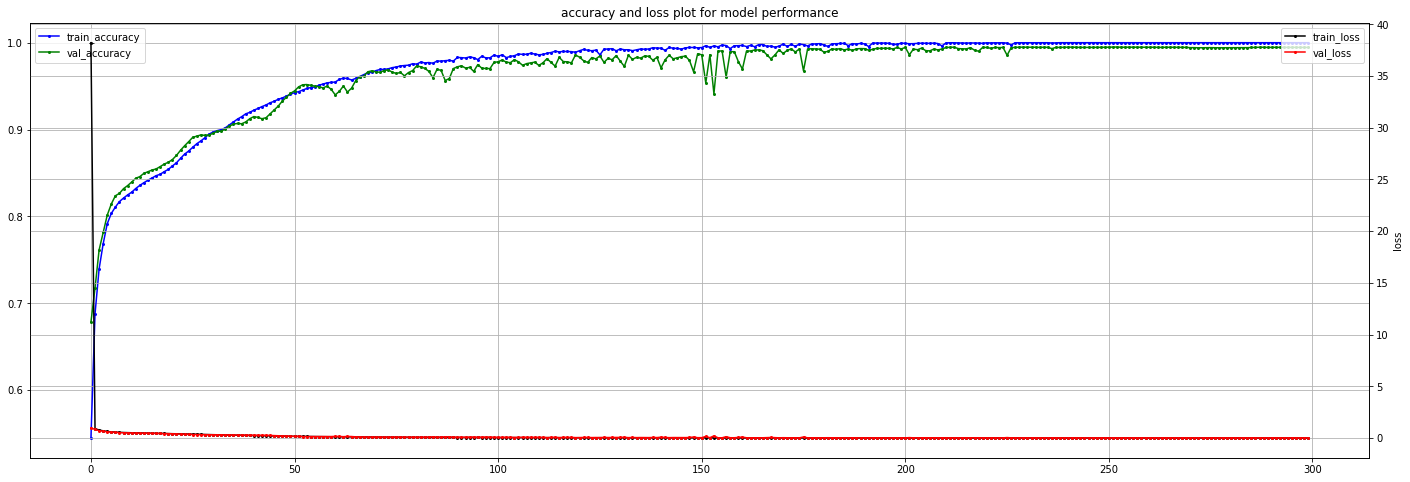

In [ ]:
plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None)

In [ ]:
y_pred = predict(model, x_test)

351/351 [==============================] - 2s 4ms/step


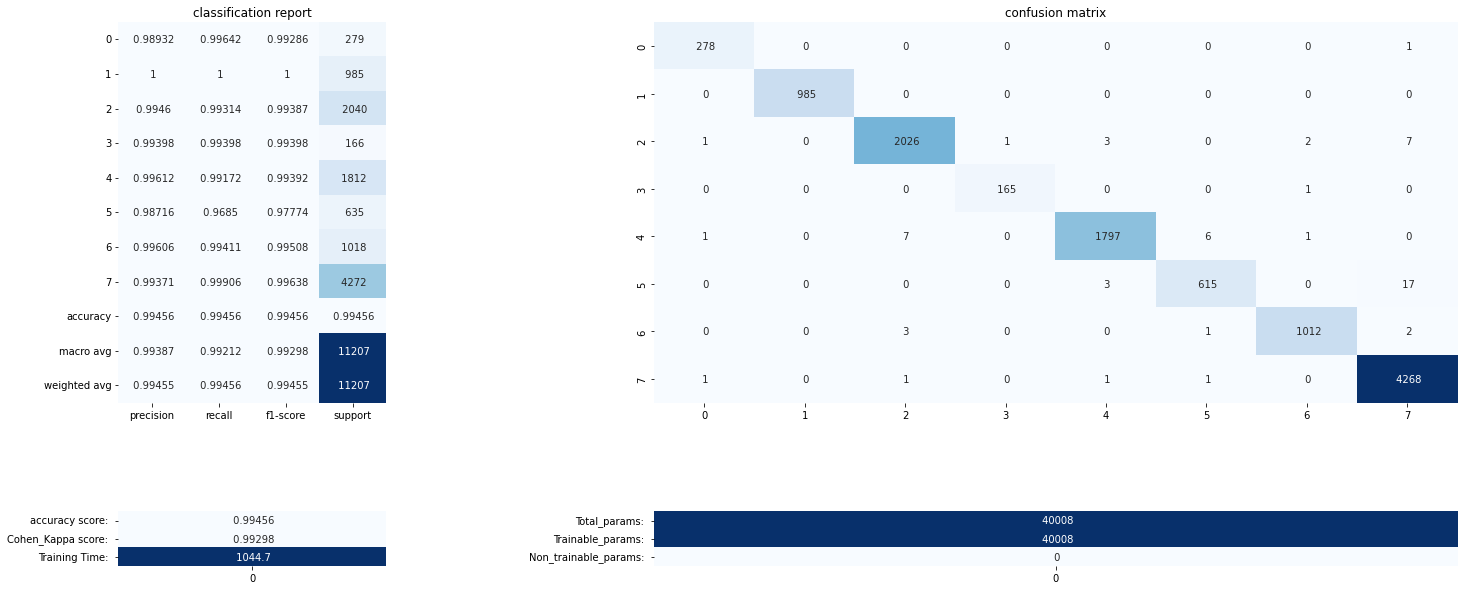

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, use_pearson_corr = None, folder_path = folder_path)

In [ ]:
for i in range(10):
    gc.collect()

In [ ]:
if use_pearson_corr:
    filepath1 = folder_path +"Results/ "+ str(train_percent)+"% performance.txt"
else:
    filepath1 = folder_path +"Results/"+ str(train_percent)+"% performance300_ps_"+str(P_S)+".txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(" ", file = open(filepath1, "a"))
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)
print("\033[1m", "Total_params: ", "\033[0m", Total_params)
print("\033[1m", "Trainable_params: ", "\033[0m", Trainable_params)
print("\033[1m", "Non_trainable_params: ", "\033[0m", Non_trainable_params)

 Confusion Matrix : 
[[ 278    0    0    0    0    0    0    1]
 [   0  985    0    0    0    0    0    0]
 [   1    0 2026    1    3    0    2    7]
 [   0    0    0  165    0    0    1    0]
 [   1    0    7    0 1797    6    1    0]
 [   0    0    0    0    3  615    0   17]
 [   0    0    3    0    0    1 1012    2]
 [   1    0    1    0    1    1    0 4268]]
 Report :  
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       279
           1       1.00      1.00      1.00       985
           2       0.99      0.99      0.99      2040
           3       0.99      0.99      0.99       166
           4       1.00      0.99      0.99      1812
           5       0.99      0.97      0.98       635
           6       1.00      0.99      1.00      1018
           7       0.99      1.00      1.00      4272

    accuracy                           0.99     11207
   macro avg       0.99      0.99      0.99     11207
weighted avg       0.99   

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)
if use_pearson_corr:
    img_path = folder_path +"Results/with_corr_"+str(train_percent)+"%_hyper_mixer_ps"+str(P_S)+".csv"
else:
    img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_hyper_mixer_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(img_path, y_combined, delimiter=",")

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

In [ ]:
y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

(array([1., 2., 3., 4., 5., 6., 7., 8.]), array([ 15767, 166563,  87566,  11921, 189580,  24307,  33567, 202837]))


In [ ]:
y_hat = y_hat.reshape((H,W))

In [ ]:
img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted300_image" + ".png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)
spectral.save_rgb("available_image.png", y, colors = spectral.spy_colors)

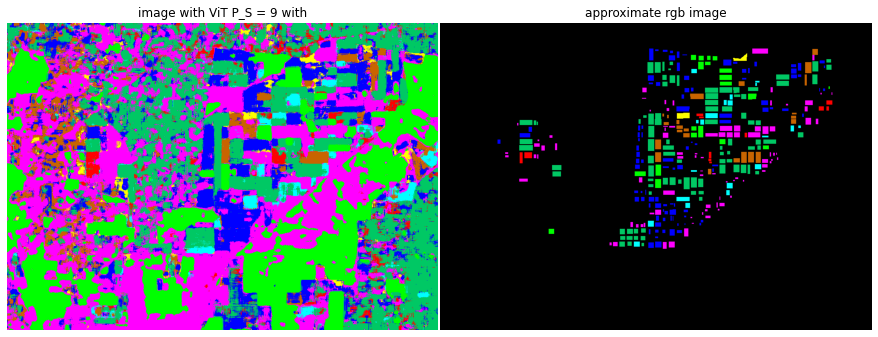

In [ ]:
img_path = folder_path + "Results/" + str(train_percent) + "% ps_" +str(P_S) + " predicted_image" + ".png"
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (12, 12))
img = plt.imread(img_path)
ax1.imshow(plt.imread(img_path))
ax1.set_title("image with ViT P_S = 9 with")
ax1.axis("off")

ax2.imshow(plt.imread("available_image.png"))
ax2.set_title("approximate rgb image")
ax2.axis("off")

plt.tight_layout(pad = 0, h_pad=0, w_pad=0.2)
plt.show()